## IMPORTS

In [1]:
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## FUNCTIONS

In [2]:
def load_ds(fname):
    '''
    Unpickles the dataset pickle and gets the descriptive dicts containing ids and vocabulary
    '''
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds, dicts

In [3]:
def new_vocab():
    '''
    Remakes the mapping for labels
    '''
    # Create a dict containing the frequency of each label
    a = {}
    for i in y_all:
        for b in i:
            if b in a.keys():
                a[b] += 1
            else:
                a[b] = 1

    # Remove the least frequent labels and rebrand them as 'Other'
    new_y, new_label = [], []
    for i in range(len(y_all)):
        tmp = [128 if a[x] < 50 else x for x in y_all[i]]
        tmpLabel = ['O' if a[x] < 50 else i2s[x] for x in y_all[i]]
        new_y.append(tmp)
        new_label.append(tmpLabel)

    # Create a set containing the remaining labels
    b = set()
    for i in new_label:
        for j in i:
            b.add(j)

    label2idx = {u:i+1 for i, u in enumerate(b)}
    idx2label = {i+1:u for i, u in enumerate(b)}
    return label2idx, idx2label, new_y


In [4]:
def get_train_test_sets(X,y):
    '''
    Generate train and test sets already filtered without excess 'Other' labels, padded and one-hot-encoded (for labels)
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    newX_train, newY_train  = [], []
    for i in range(len(X_train)):
        j = len(y_train[i]) - 1
        #print(i, j)
        while(y_train[i][j] == 4 and j > 0):
            j -= 1
        if j != 0:
            newX_train.append(X_train[i][:j+1])
            newY_train.append(y_train[i][:j+1])
    X_train = pad_sequences(newX_train, padding='post', maxlen=42)
    y_train = pad_sequences(newY_train, padding='post', maxlen=42)
    X_test = pad_sequences(X_test, padding='post', maxlen=42)
    y_test = pad_sequences(y_test, padding='post', maxlen=42)
    y_test = [to_categorical(i, num_classes=LABEL) for i in y_test]
    y_train = [to_categorical(i, num_classes=LABEL) for i in y_train]
    return X_train, X_test, y_train, y_test

In [5]:
def evaluate_model(model, X_test, y_test):
    '''
    Tests trained model and generates a classification report and a confusion matrix
    '''
    Y_pred = model.predict(X_test)
    
    Y_pred_max = tf.argmax(tf.nn.softmax(Y_pred), -1).numpy().flatten()
    y_test_max =tf.argmax(y_test, axis=-1).numpy().flatten()
    y_no_pad = [(p,y) for p,y in zip(Y_pred_max, y_test_max) if y != 0]
    pred = [x[0] for x in y_no_pad]
    true = [x[1] for x in y_no_pad]

    fig, ax = plt.subplots(figsize=(30,30))       
    sns.heatmap(confusion_matrix(pred, true), annot=True, vmax=100, ax=ax)

    print(classification_report(pred, true, zero_division=False))

## LOAD DATASET AND GET TOKENS, SLOTS AND INTENTS, AND THEIR INDEXES

In [6]:
train_ds, dicts = load_ds('atis.train.pkl')
test_ds, _ = load_ds('atis.test.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26


In [7]:
t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t, i2s, i2in = map(lambda d: {d[k]: k for k in d.keys()}, [t2i, s2i, in2i])
query, slots, intent = map(train_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

In [8]:
t2i_test, s2i_test, in2i_test = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t_test, i2s_test, i2in_test = map(lambda d: {d[k]: k for k in d.keys()}, [t2i_test, s2i_test, in2i_test])
query_test, slots_test, intent_test = map(test_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

## GENERATE X AND Y PAIRING

In [9]:
X = query + query_test
y = slots + slots_test

x_text, y_all = [], []
for i, k in zip(X, y):
    tmp,tmpy = [], []
    for j, l in zip(i, k):
        if i2t[j] != "EOS" and i2t[j] != "BOS":
            tmp.append(j)
            tmpy.append(l)
    x_text.append(tmp)
    y_all.append(tmpy)

In [10]:
l2i, i2l, new_y = new_vocab()

In [11]:
# Converts text query to id
X, y = [], []
for i in range(len(x_text)):
    tmp = [x for x in x_text[i]]
    tmp2 = [l2i[i2s[x]] for x in new_y[i]]
    X.append(tmp)
    y.append(tmp2)

### HYPERPARAMETERS AND PARAMETERS

In [12]:
BATCH_SIZE = 64
EMBEDDING_DIM = 128
UNITS = 128
EPOCHS= 4
LABEL = len(i2l)+1
VOCABULARY = len(dicts['token_ids'])+1
INPUT_LENGTH = 42
INPUT_DIM = len(x_text)+1
OUTPUT_DIM=64

In [13]:
X_train, X_test, y_train, y_test = get_train_test_sets(X,y)

## MODEL DEFINITION AND COMPILING

In [14]:
model = Sequential()
model.add(Embedding(input_dim=INPUT_DIM, output_dim=UNITS, input_length=INPUT_LENGTH))
model.add(Bidirectional(GRU(units=UNITS, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), merge_mode = 'concat'))
model.add(GRU(units=UNITS, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(TimeDistributed(Dense(LABEL, activation="relu")))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 42, 128)           751616    
_________________________________________________________________
bidirectional (Bidirectional (None, 42, 256)           198144    
_________________________________________________________________
gru_1 (GRU)                  (None, 42, 128)           148224    
_________________________________________________________________
time_distributed (TimeDistri (None, 42, 57)            7353      
Total params: 1,105,337
Trainable params: 1,105,337
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, verbose=1, epochs=EPOCHS, validation_split=0.2)

Epoch 1/4
59/59 [==============================] - 54s 668ms/step - loss: 0.9222 - accuracy: 0.8709 - val_loss: 0.4815 - val_accuracy: 0.9039
Epoch 2/4
59/59 [==============================] - 42s 709ms/step - loss: 0.4068 - accuracy: 0.9082 - val_loss: 0.3061 - val_accuracy: 0.9082
Epoch 3/4
59/59 [==============================] - 43s 733ms/step - loss: 0.3504 - accuracy: 0.9051 - val_loss: 0.2837 - val_accuracy: 0.9111
Epoch 4/4
59/59 [==============================] - 45s 765ms/step - loss: 0.2768 - accuracy: 0.9173 - val_loss: 0.2237 - val_accuracy: 0.9438


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.02      1.00      0.04         1
           2       0.00      0.00      0.00         0
           3       0.06      1.00      0.11         1
           4       0.00      0.00      0.00         0
           5       0.33      0.75      0.46         8
           6       0.04      0.25      0.07         4
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.13      0.92      0.22        12
          10       0.10      1.00      0.19        18
          11       0.16      0.65      0.25        17
          12       0.00      0.00      0.00         0
          13       0.02      1.00      0.05         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.22      1.00      0.36        22
          17       0.00    

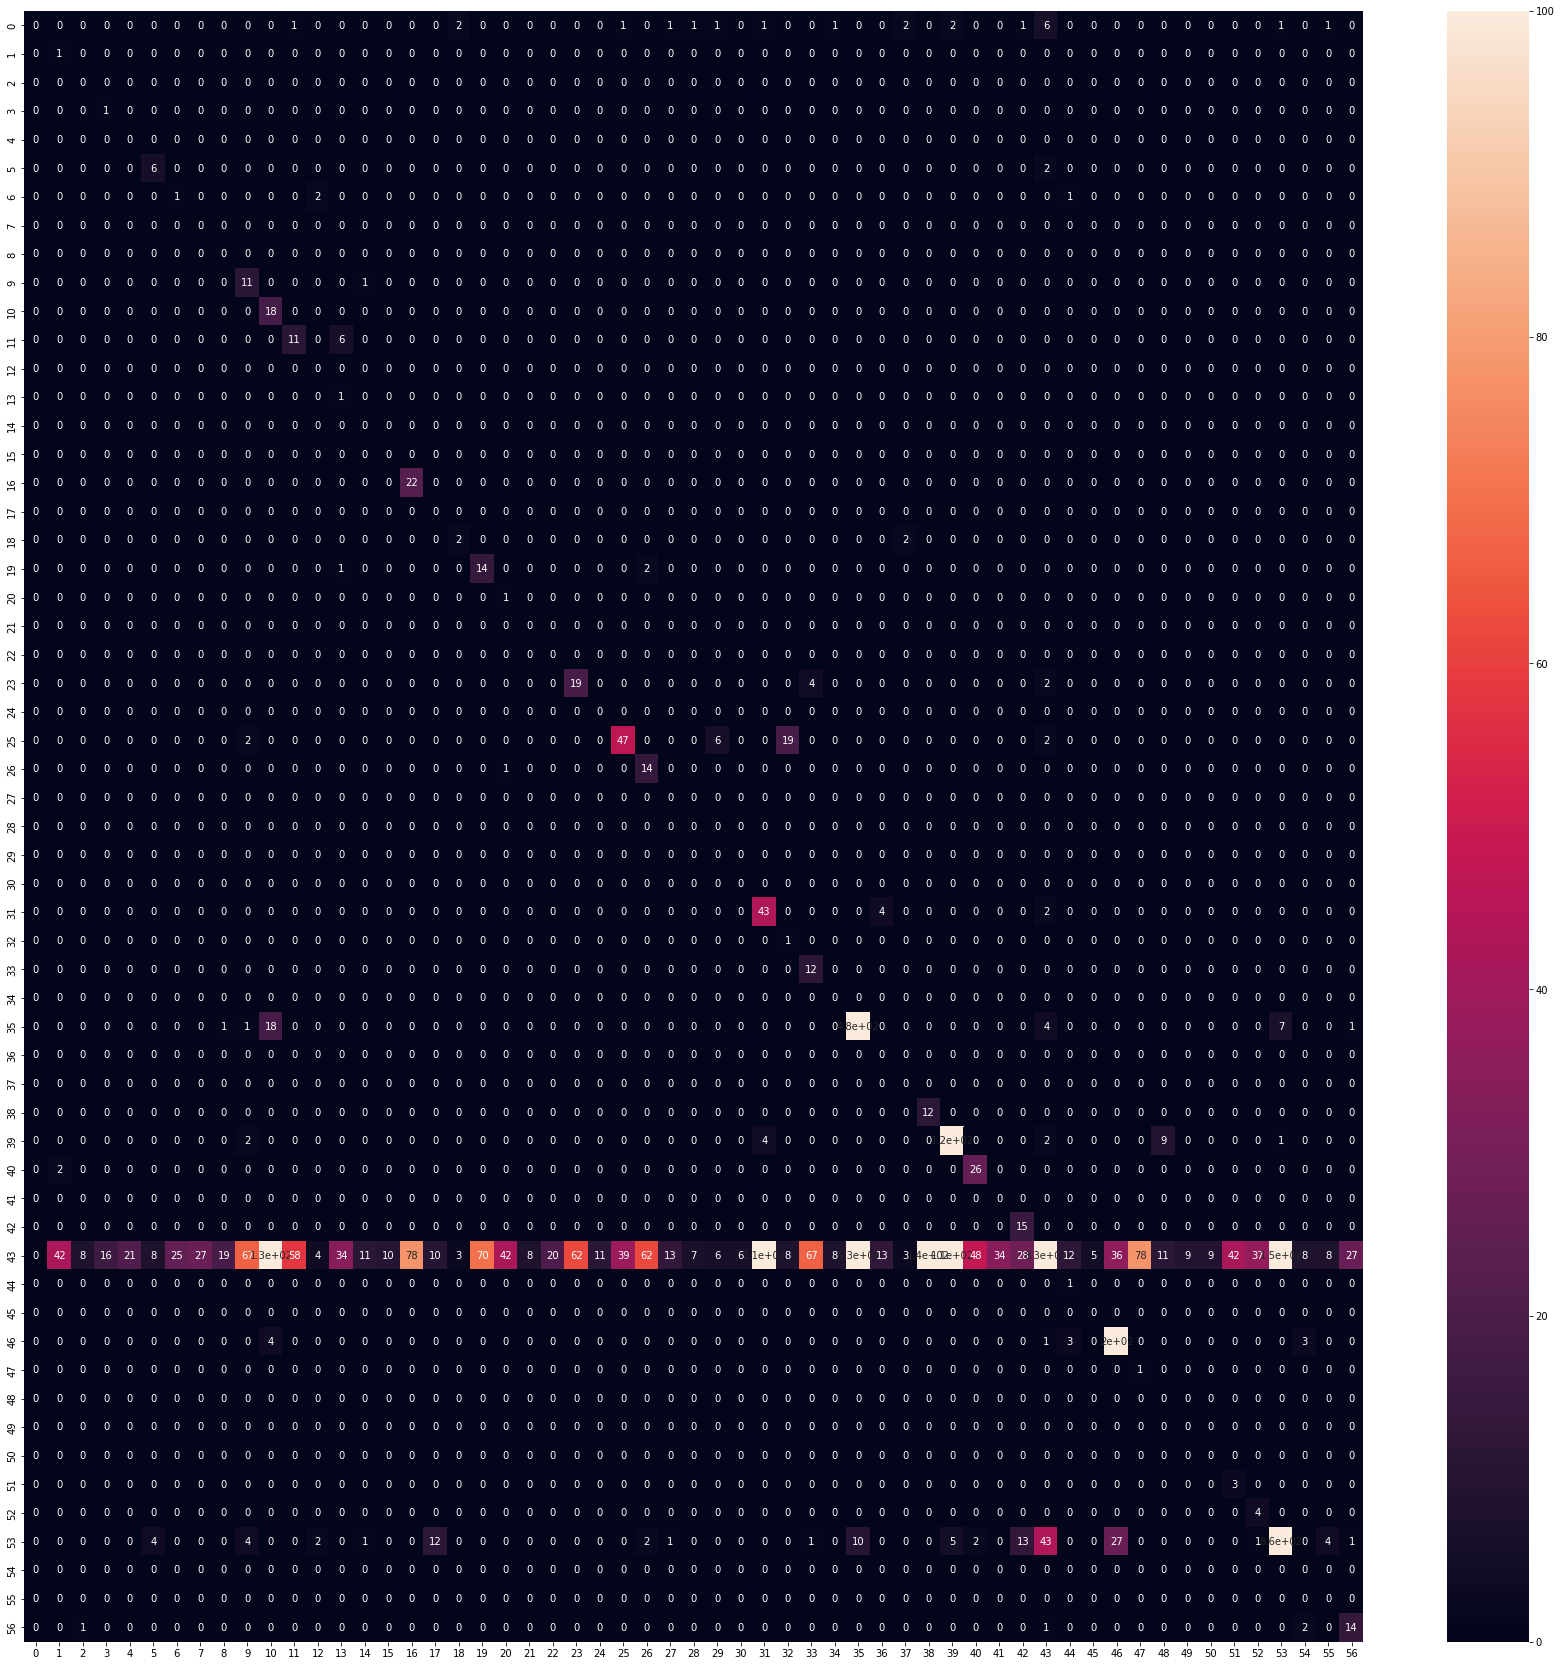

In [16]:
evaluate_model(model, X_test, y_test)